In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential

## MNIST データセットをロード

- Keras が配布してくれているので、別途ダウンロードしてきてフォルダに保存などの手間なく、下記のコードでロードできる

### データセット

- x_train: 学習用データ（入力画像, 28x28 のグレースケール, 60,000枚）
- y_train: 学習用データ（正解ラベル）
- x_test: テスト用データ（入力画像, 10,000枚）
- y_test: テスト用データ（正解ラベル）

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## 画像を可視化してみる

- 白黒ではなく、なぜか白いほど黄色・黒いほど紫で表示されるのがデフォルトなので注意

(<matplotlib.image.AxesImage at 0x7f633d36a290>, 5)

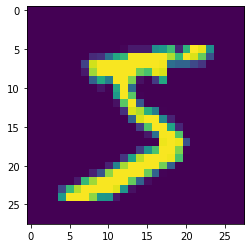

In [ ]:
plt.imshow(x_train[0]), y_train[0]

# 以下2行を追加でグレースケールで表示される
# plt.gray()
# plt.show()

## 前処理

- 0-1 正規化
- チャネルの次元を追加し、モデルの入力に形状を合わせる
- 型を変換（エラー出たので汗）
- （ラベルの One-hot 化なども必要に応じて行う）

In [ ]:
# 0-1 正規化 
x_train = x_train / 255.0
x_test = x_test / 255.0

# 次元の追加
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# 型の変換
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

## モデルの定義（Sequential API）

- tensorflow.keras.model.Sequential クラスに、配列で各層を与える
- tensorflow.keras.layers 内に色々なレイヤーのベースがある
- Colab の場合、Conv2D などのクラス名部分にカーソルを置いて少し待つと、そのクラスの情報が得られる

In [ ]:
input_shape = x_train.shape[1:]
output_dim = 10

model = Sequential([
    Conv2D(32, 3, padding="same", activation="relu", name="conv_1", input_shape=input_shape),
    MaxPool2D(name="pool_1"),
    Conv2D(64, 3, padding="same", activation="relu", name="conv_2"),
    MaxPool2D(name="pool_2"),
    Conv2D(128, 3, padding="same", activation="relu", name="conv_3"),
    Flatten(),
    Dense(1024, activation="relu", name="dense_1"),
    Dense(256, activation="relu", name="dense_2"),
    Dense(output_dim, activation="softmax", name="dense_3"),
])

## 完成したモデルの情報を確認

- summay() は Sequential API を用いた形式で、初めのレイヤーに引数 input_shape を定義しなければ見れない
  - キーワード：Define and Run と Define by Run
- Keras のユーティリティ関数 model_to_dot() を使用して SVG の取得も可能
- summary()：文字列なのでターミナルでも容易に確認可能、model_to_dot()：スライドや論文に貼り付けたい場合、など適宜使い分け

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 conv_3 (Conv2D)             (None, 7, 7, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              6

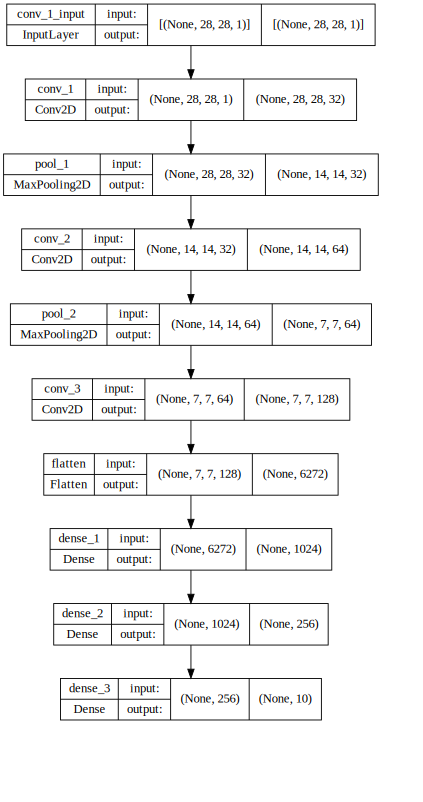

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

最適化手法・損失関数・評価指標を設定

- 各種クラスを継承して、独自のクラスを作成することも可能
  - 例えば Contrastive Learning なら、Loss 関数を独自のものに置き換えています
- もしラベルデータが One-hot 化されていたら、SparseCategoricalCrossentropy の代わりに CategoricalCrossentropy を使用することができる

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

## 学習

- データやその他情報を与えて fit() メソッドを呼び出すと学習が開始される
  - すなわち GPU をぶん回す関数
  - 深層学習が何時間・何日とかかかるとか言ってるのも、基本はこの関数の実行のこと

###fit() の出力の見方

- fit() では、いい感じに学習の状況を表示してくれる
  - 普通（PyTorch や Tensorflow でも fit() を使わずに学習する場合）は毎ターン呼び出した学習用の関数の戻り値として結果が返ってくるので、それを print() するなどの記述が必要

Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0318 - accuracy: 0.9909

- Epoch 3/10：
  - 全体で何エポックあり、うち現在何エポック目か
- 1875/1875：
  - 全体のバッチ数と、うち何番目のデータを処理中か
    - バッチサイズは fit() メソッドの引数 batch_size として指定可能
    - 省略するとデフォルトは 32
    - なので、今回であれば学習用データが 60,000 枚でバッチサイズが 32 なので、順伝搬・逆伝搬＆重み更新が 60,000 / 32 = 1,875 回行われることになる
    - batch_size=1 なら1データずつ重み更新を行うオンライン学習、batch_size=<データ数> なら全データを踏まえて1度の重み更新を行うバッチ学習
  - 8s：
    - 1エポックの処理時間（1エポック目はその他の準備等で長くなることが多い）
  - 4ms/step：
    - 1バッチの処理時間（8s / 1875epoch ≒ 4ms/step）
  - loss: 0.0318 - accuracy: 0.9909
    - 先ほど指定した Loss と Accuracy
    - その他の指標を指定や追加していれば、それに応じて表示が変わる
    - また、validation データを指定していた場合、エポックごとに学習データ・検証データ別に結果を得られる（）

In [ ]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0042 - accuracy: 0.9989
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0087 - accuracy: 0.9983
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0044 - accuracy: 0.9991
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0082 - accuracy: 0.9984
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0074 - accuracy: 0.9987
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0079 - accuracy: 0.9988
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0052 - accuracy: 0.9992
Epoch 8/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0071 - accuracy: 0.9989
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0130 - accuracy: 0.9980
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.004

## テスト

### 予測

- predict() メソッドを入力データを与えて呼び出す
- 1データずつ for 文を回してもよいが、全データをそのままガツンと入力して全部計算させることも可能
- y_pred には Softmax 前の10次元ベクトルが返ってくる
  - Sequential() に渡して構築したモデルの出力は Softmax 前の値で、Loss 計算時に合わせて Softmax しているため

In [ ]:
y_pred = model.predict(x_test)
y_pred, y_pred.shape

(array([[4.8937072e-18, 6.8083711e-13, 1.9390435e-12, ..., 1.0000000e+00,
         1.0532149e-19, 7.9470608e-10],
        [5.9848883e-23, 3.1845283e-19, 1.0000000e+00, ..., 4.6979428e-19,
         2.0446887e-20, 5.6855104e-26],
        [5.9265487e-22, 1.0000000e+00, 5.4487846e-15, ..., 3.2768340e-16,
         5.9933201e-15, 1.0901179e-20],
        ...,
        [3.0955448e-28, 2.2876518e-23, 6.4136201e-25, ..., 5.2903217e-21,
         2.0060045e-21, 8.7369739e-16],
        [5.8358207e-23, 9.7657177e-21, 9.2174623e-30, ..., 3.0397414e-19,
         3.1143981e-15, 2.5534991e-17],
        [2.5115758e-14, 2.5137766e-17, 2.5400826e-17, ..., 2.3068543e-21,
         2.3880899e-17, 1.6310285e-25]], dtype=float32), (10000, 10))

- Softmax 前後で大小関係は変わらないので、そのまま予測ラベルに変換する
- (0 から数えて) 1次元目の max をとり、そのインデックスを返す

In [ ]:
y_pred = y_pred.argmax(axis=1)

- Accuracy を計算

In [ ]:
num = 0
for pred, true in zip(y_pred, y_test):
    if pred == true:
        num += 1

# 1行でも書ける（インポートは除いて）
# import numpy as np
# num = np.count_nonzero(y_pred == y_test)

print(f'Accuracy: {num / len(y_test):.2%}')

Accuracy: 99.19%


- predict で予測を受け取って後処理しなくても、実は evaluate() メソッドで1発

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0368 - accuracy: 0.9919


[0.036786194890737534, 0.9919000267982483]

## 付録

### 検証データで評価する

- fit() メソッドの引数で validation_split を指定すると、学習データのうちそれだけの割合のデータが検証データとして扱われる
- 引数 validation_data にタプルで指定することも可能

In [ ]:
model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0123 - val_accuracy: 0.9967
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0089 - accuracy: 0.9979 - val_loss: 0.0171 - val_accuracy: 0.9949
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0112 - accuracy: 0.9972 - val_loss: 0.0236 - val_accuracy: 0.9951
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0088 - accuracy: 0.9977 - val_loss: 0.0154 - val_accuracy: 0.9963
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0083 - accuracy: 0.9980 - val_loss: 0.0326 - val_accuracy: 0.9927
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0141 - val_accuracy: 0.9969
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0211 - val_accuracy:

In [ ]:
# 簡易的に分割
# 本来は sciket-learn の train_test_split() を引数 stratify にラベルを指定して分割などするべき
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]

model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 0.0117 - val_accuracy: 0.9977
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.0178 - val_accuracy: 0.9970
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.0213 - val_accuracy: 0.9945
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 0.0290 - val_accuracy: 0.9954
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0285 - val_accuracy: 0.9967
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.0316 - val_accuracy: 0.9951
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0327 - val_accurac

### 学習曲線の描画

- matplotlib を用いる
- fit() の戻り値に Loss や Accuracy が入っている

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 0.0322 - val_accuracy: 0.9937
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0831 - val_accuracy: 0.9940
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0092 - accuracy: 0.9987 - val_loss: 0.0474 - val_accuracy: 0.9958
Epoch 4/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0112 - accuracy: 0.9986 - val_loss: 0.0496 - val_accuracy: 0.9938
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0411 - val_accuracy: 0.9946
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.0579 - val_accuracy: 0.9934
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0061 - accuracy: 0.9991 - val_loss: 0.0589 - val_accuracy:

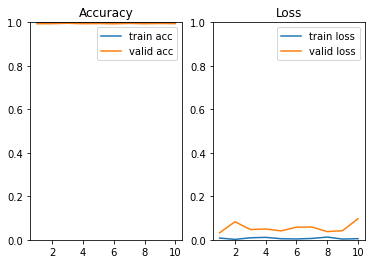

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

result = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(range(1, 11), result.history['accuracy'], label="train acc")
axes[0].plot(range(1, 11), result.history['val_accuracy'], label="valid acc")
axes[0].set_title('Accuracy')
axes[0].set_ylim(0.0, 1.0)
axes[0].legend()
axes[1].plot(range(1, 11), result.history['loss'], label="train loss")
axes[1].plot(range(1, 11), result.history['val_loss'], label="valid loss")
axes[1].set_title('Loss')
axes[1].set_ylim(0.0, 1.0)
axes[1].legend()
plt.show()

### 余談

print() とかして <class at 0x0000> みたいな表示が出ることがある。
これは、class名とその場所（C言語で言うところのポインタ的な）が表示されている。
原因はそのクラスに print() をした時の戻り値が定義されていないから。
具体的には、__repr__() という関数を定義し、戻り値を返すよう実装すれば良い

In [ ]:
class A:
    pass

class B:
    def __repr__(self):
        return 'class B'

a = A()
b = B()

a, b

(<__main__.A at 0x7f63bdbca2d0>, class B)

### さらに余談

__repr__() 以外にも、デフォルト定義の関数は色々ある。
例えば、割り算(/)の定義は __truediv__() を定義すれば上書きできる。
パスを操作する Pathlib というライブラリ（の Path クラス）では、割り算にパスの連結を定義している。

In [ ]:
from pathlib import Path

dir = Path('dir')
file = Path('file.txt')

dir / file

PosixPath('dir/file.txt')